In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import requests
from bs4 import BeautifulSoup as BS
import re
import warnings
import folium
import bokeh
from numpy import NaN
import matplotlib.pyplot as plt
import scrapy
from pybaseball import pitching_stats
from pybaseball import statcast_single_game,statcast_pitcher,pitching_stats_bref
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import schedule_and_record
import seaborn as sns


from sklearn import metrics
from sklearn.cluster import k_means,KMeans,hierarchical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [2]:
cluster_data = pd.read_csv('cluster_data.csv')

cluster_data = cluster_data.drop(columns=['Age','WAR','Pace (pi)', 'Contact% (pi)','Zone% (pi)'])

awards_players = pd.read_csv('AwardsPlayers.csv')

People = pd.read_csv('People.csv')

In [3]:
awards_players = pd.merge(awards_players,People,on='playerID')

In [4]:
awards_players_2006 = awards_players.loc[awards_players['yearID'] >= 2006]

In [5]:
cy_young = awards_players_2006.loc[awards_players_2006['awardID'] == 'Cy Young Award']

cy_young = cy_young[['playerID','awardID','yearID','lgID','nameFirst','nameLast']]

cy_young['Name'] = cy_young['nameFirst'] + ' ' + cy_young['nameLast']

cy_young = cy_young.drop(columns=['nameFirst','nameLast'])

cy_young['Winner'] = True

cy_young = cy_young.rename(columns={'yearID':'Season'})

cy_young = cy_young.drop(columns=['lgID','playerID','awardID'])

cy_young.head()

Season              Name  Winner
5456    2010      Roy Halladay    True
5513    2006     Johan Santana    True
5626    2006      Brandon Webb    True
5638    2011  Justin Verlander    True
5708    2007       CC Sabathia    True

In [6]:
cluster_data = pd.merge(cluster_data,cy_young,how='left')

In [7]:
cluster_data = cluster_data.fillna(False)

In [8]:
cluster_data['Winner'] = cluster_data['Winner'].astype(int)

In [9]:
cluster_data = cluster_data[['Season','Name','Winner','IP','K/9','BB/9','tERA','HR/9','LOB%','FIP','GB/FB','BABIP','K%','BB%','SwStr%']]

## Cluster Time

In [10]:
cluster_data.loc[(cluster_data['Name']=='Jacob deGrom') & (cluster_data['Season'] == 2018.0),'Winner'] = 1

cluster_data.loc[(cluster_data['Name']=='Blake Snell') & (cluster_data['Season'] == 2018.0),'Winner'] = 1

cluster_data.head()

Season              Name  Winner     IP    K/9  BB/9  tERA  HR/9   LOB%  \
0  2018.0      Jacob deGrom       1  217.0  11.16  1.91  2.15  0.41  0.820   
1  2011.0      Roy Halladay       0  233.2   8.47  1.35  2.46  0.39  0.781   
2  2015.0   Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58  0.783   
3  2009.0      Zack Greinke       1  229.1   9.50  2.00  2.55  0.43  0.793   
4  2009.0  Justin Verlander       0  240.0  10.09  2.36  3.18  0.75  0.727   

    FIP  GB/FB  BABIP     K%    BB%  SwStr%  
0  1.99   1.47  0.281  0.322  0.055   0.151  
1  2.20   1.67  0.298  0.236  0.038   0.109  
2  1.99   1.77  0.281  0.338  0.047   0.159  
3  2.33   0.99  0.303  0.265  0.056   0.100  
4  2.80   0.84  0.319  0.274  0.064   0.114

In [11]:
X = cluster_data.iloc[:, 3:15].values  
y = cluster_data.iloc[:, :3].values 

In [12]:
X

array([[2.170e+02, 1.116e+01, 1.910e+00, ..., 3.220e-01, 5.500e-02,
        1.510e-01],
       [2.332e+02, 8.470e+00, 1.350e+00, ..., 2.360e-01, 3.800e-02,
        1.090e-01],
       [2.322e+02, 1.164e+01, 1.620e+00, ..., 3.380e-01, 4.700e-02,
        1.590e-01],
       ...,
       [1.091e+02, 4.030e+00, 3.620e+00, ..., 9.600e-02, 8.600e-02,
        5.700e-02],
       [1.990e+02, 4.880e+00, 2.040e+00, ..., 1.260e-01, 5.300e-02,
        5.900e-02],
       [4.010e+01, 6.470e+00, 6.920e+00, ..., 1.440e-01, 1.540e-01,
        6.900e-02]])

In [13]:
y

array([[2018.0, 'Jacob deGrom', 1],
       [2011.0, 'Roy Halladay', 0],
       [2015.0, 'Clayton Kershaw', 0],
       ...,
       [2010.0, 'Ryan Rowland-Smith', 0],
       [2011.0, 'Bronson Arroyo', 0],
       [2011.0, 'Scott Proctor', 0]], dtype=object)

In [14]:
scaler = StandardScaler()
 
X_scaled = scaler.fit_transform(X) 

In [15]:
kmeans = KMeans(n_clusters=1000, max_iter=1000, algorithm = 'auto')

#kmeans_messy = KMeans(n_clusters=3, max_iter=1000, algorithm = 'auto')
kmeans.fit_transform(X_scaled)

array([[ 5.27435457,  3.15652897,  3.84637557, ..., 11.0521268 ,
         5.02490979,  7.02816675],
       [ 4.40241318,  2.14838636,  3.62219189, ..., 10.37581191,
         3.47770334,  6.37535926],
       [ 5.67342118,  3.52065759,  4.20128579, ..., 11.47513181,
         5.40649565,  7.2811435 ],
       ...,
       [ 2.87934337,  3.74344489,  4.30855253, ...,  7.16571049,
         1.6653257 ,  5.6669161 ],
       [ 3.51844364,  3.29555336,  4.42137604, ...,  8.73235481,
         1.19374144,  6.50202901],
       [ 2.81365608,  4.67985235,  4.47607219, ...,  6.00988993,
         3.6443819 ,  5.90271303]])

In [16]:
#gm_messy = GaussianMixture(n_components=3).fit(X).predict(X)

#plt.scatter(X[:,11], X[:,4], c=gm_messy, cmap='plasma')

#fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
#print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
#fig_size[0] = 12
#fig_size[1] = 9
#plt.scatter(kmeans.cluster_centers_[:,10] ,kmeans.cluster_centers_[:,3], color='black') 

In [17]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

In [18]:
X_r

array([[-3.95691831,  0.42777593],
       [-2.79953279, -1.31667761],
       [-4.17674119,  0.49385503],
       ...,
       [ 1.92378861, -1.51017552],
       [ 0.68202041, -2.19567885],
       [ 2.56005999,  0.96283566]])

In [19]:
kmeans.cluster_centers_

array([[-0.14567767, -0.46605599,  0.25285053, ..., -0.42740088,
         0.44653909, -0.09236797],
       [ 0.97941   ,  0.32951841, -0.77580137, ...,  0.45906563,
        -0.88397228,  0.38308564],
       [-0.43750396,  0.74446164, -0.50018024, ...,  0.96821044,
        -0.45853156,  0.41038288],
       ...,
       [-1.01958636, -2.76085632,  4.60849138, ..., -2.60835136,
         3.99305576, -0.31347558],
       [ 1.55414754, -0.80357973, -0.54792932, ..., -0.75604923,
        -0.6350168 , -0.56741694],
       [-1.02125315, -1.06797083,  0.23667731, ..., -1.33754698,
        -0.08021626,  1.81378192]])

In [20]:
print(kmeans.labels_)

[130 622 130 ...   4 122 179]


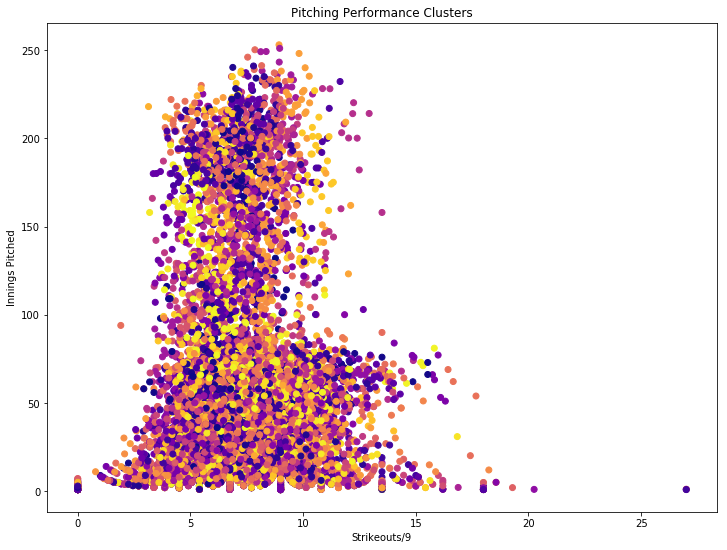

<Figure size 1440x720 with 0 Axes>

In [54]:
plt.scatter(X[:,1], X[:,0], c=kmeans.labels_, cmap='plasma')
plt.xlabel('Strikeouts/9')
plt.ylabel('Innings Pitched')
plt.title('Pitching Performance Clusters')
plt.figure(figsize=(20,10))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
#plt.scatter(kmeans.cluster_centers_[:,1] ,kmeans.cluster_centers_[:,0], color='gold') 

In [22]:
cluster_data['Cluster'] = kmeans.predict(X_scaled)

In [23]:
cluster_data.head()

Season              Name  Winner     IP    K/9  BB/9  tERA  HR/9   LOB%  \
0  2018.0      Jacob deGrom       1  217.0  11.16  1.91  2.15  0.41  0.820   
1  2011.0      Roy Halladay       0  233.2   8.47  1.35  2.46  0.39  0.781   
2  2015.0   Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58  0.783   
3  2009.0      Zack Greinke       1  229.1   9.50  2.00  2.55  0.43  0.793   
4  2009.0  Justin Verlander       0  240.0  10.09  2.36  3.18  0.75  0.727   

    FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  
0  1.99   1.47  0.281  0.322  0.055   0.151      130  
1  2.20   1.67  0.298  0.236  0.038   0.109      622  
2  1.99   1.77  0.281  0.338  0.047   0.159      130  
3  2.33   0.99  0.303  0.265  0.056   0.100      351  
4  2.80   0.84  0.319  0.274  0.064   0.114      780

In [70]:
cm = sns.light_palette("xkcd:light gold", as_cmap=True)

aroldis_chapman = cluster_data.loc[cluster_data['Name']=='Aroldis Chapman']

aroldis_chapman.style.background_gradient(cmap=cm)

In [51]:
len(cluster_data.loc[cluster_data['Cluster']==248])

8

In [71]:
cluster_248 = cluster_data.loc[cluster_data.Cluster == 248]

cluster_248.style.background_gradient(cmap=cm)

In [72]:
winner_data = cluster_data.loc[cluster_data['Winner']==1]

winner_data.style.background_gradient(cmap=cm)

In [63]:
Counter(winner_data.Cluster).most_common()

[(351, 8),
 (414, 3),
 (780, 3),
 (130, 2),
 (888, 2),
 (477, 2),
 (622, 2),
 (883, 1),
 (69, 1),
 (794, 1)]

In [28]:
Cy_young_yes = ['Jacob deGrom','Zack Greinke','Clayton Kershaw','Tim Lincecum',
 'Corey Kluber',
 'Jake Arrieta',
 'Cliff Lee',
 'Felix Hernandez',
 'Jake Peavy',
 'Johan Santana',
 'Justin Verlander',
 'Brandon Webb',
 'CC Sabathia',
 'Roy Halladay',
 'Max Scherzer',
 'Dallas Keuchel',
 'Rick Porcello',
 'Blake Snell',
 'David Price']

In [29]:
cluster_data['Cy_young_winner'] = np.where(cluster_data["Name"].isin(Cy_young_yes), 1, 0)

Counter(cluster_data.Cy_young_winner)

Counter({1: 175, 0: 8711})

In [30]:
all_cy_young_seasons = cluster_data.loc[cluster_data.Cy_young_winner == 1]

Counter(all_cy_young_seasons.Cluster).most_common();

In [65]:
print(cluster_data.loc[cluster_data['Name']=="Clayton Kershaw"])

print(cluster_data.loc[cluster_data['Cluster']==130]);

      Season             Name  Winner     IP    K/9  BB/9  tERA  HR/9   LOB%  \
2     2015.0  Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58  0.783   
5     2014.0  Clayton Kershaw       1  198.1  10.85  1.41  1.84  0.41  0.816   
8     2011.0  Clayton Kershaw       1  233.1   9.57  2.08  2.48  0.58  0.786   
13    2013.0  Clayton Kershaw       1  236.0   8.85  1.98  2.87  0.42  0.806   
37    2016.0  Clayton Kershaw       0  149.0  10.39  0.66  1.91  0.48  0.800   
43    2012.0  Clayton Kershaw       0  227.2   9.05  2.49  2.97  0.63  0.779   
174   2010.0  Clayton Kershaw       0  204.1   9.34  3.57  2.98  0.57  0.762   
194   2017.0  Clayton Kershaw       0  175.0  10.39  1.54  3.05  1.18  0.874   
242   2009.0  Clayton Kershaw       0  171.0   9.74  4.79  3.07  0.37  0.775   
424   2018.0  Clayton Kershaw       0  161.1   8.65  1.62  3.59  0.95  0.787   
1679  2008.0  Clayton Kershaw       0  107.2   8.36  4.35  4.36  0.92  0.757   

       FIP  GB/FB  BABIP     K%    BB% 

In [32]:
Counter(cluster_data.Cy_young_winner).most_common()

[(0, 8711), (1, 175)]

In [66]:
cy_young_cluster = cluster_data.loc[cluster_data['Cluster']==351]

In [67]:
print('Number of cy young seasons in this cluster:',cy_young_cluster['Winner'].sum())

print('Number of cy young winners in this cluster', cy_young_cluster['Cy_young_winner'].sum())

print('Total # of pitchers:',len(cy_young_cluster))

Number of cy young seasons in this cluster: 8
Number of cy young winners in this cluster 11
Total # of pitchers: 15


In [73]:
cy_young_cluster.sort_values(by='Winner',ascending=False).head(10)

cy_young_cluster.style.background_gradient(cmap=cm)

In [76]:
print(cluster_data.groupby('Cluster')['Cy_young_winner'].sum().sort_values(ascending=False).head(10))

Cluster
780    17
622    13
351    11
466     9
477     7
414     6
888     6
115     6
22      5
292     5
Name: Cy_young_winner, dtype: int64


In [37]:
grouped = cluster_data.groupby('Cluster')
grouped.get_group(1)

Season             Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
235   2014.0     Hyun-Jin Ryu       0  152.0  8.23  1.72  3.07  0.47  0.718   
329   2015.0   Michael Pineda       0  160.2  8.74  1.18  3.88  1.18  0.686   
340   2016.0     James Paxton       0  121.0  8.70  1.79  3.15  0.67  0.663   
364   2017.0         Jon Gray       0  110.1  9.14  2.45  4.26  0.82  0.748   
387   2014.0   Marcus Stroman       0  130.2  7.65  1.93  3.09  0.48  0.684   
428   2015.0    Clay Buchholz       0  113.1  8.50  1.83  3.24  0.48  0.704   
559   2013.0     Corey Kluber       0  147.1  8.31  2.02  4.33  0.92  0.729   
564   2006.0     A.J. Burnett       0  135.2  7.83  2.59  4.10  0.93  0.713   
651   2018.0     Shane Bieber       0  114.2  9.26  1.81  3.86  1.02  0.694   
706   2012.0     Jaime Garcia       0  121.2  7.25  2.22  3.40  0.52  0.691   
755   2015.0       Trevor May       0  114.2  8.63  2.04  3.68  0.86  0.735   
794   2016.0      Steven Matz       0  132.1  8.77  2.11  3.59  0.95  0.770   
813   2016.0   Tyler Anderson       0  114.1  7.79  2.20  4.60  0.94  0.751   
850   2013.0      Gerrit Cole       0  117.1  7.67  2.15  3.74  0.54  0.745   
862   2018.0        Alex Wood       0  151.2  8.01  2.37  3.94  0.83  0.706   
933   2018.0   Nathan Eovaldi       0  111.0  8.19  1.62  3.73  1.14  0.673   
934   2018.0     Joe Musgrove       0  115.1  7.80  1.79  3.79  0.94  0.692   
990   2016.0         Joe Ross       0  105.0  7.97  2.49  4.67  0.77  0.767   
1042  2010.0     Matt Belisle       0   92.0  8.90  1.57  3.51  0.68  0.738   
1116  2016.0    Matt Andriese       0  127.2  7.68  1.76  3.75  1.20  0.698   
1178  2015.0  Hisashi Iwakuma       0  129.2  7.70  1.46  3.76  1.25  0.756   
1296  2015.0   Patrick Corbin       0   85.0  8.26  1.80  4.34  0.95  0.780   
1370  2012.0       Dillon Gee       0  109.2  7.96  2.38  3.91  0.98  0.689   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
235   2.62   1.58  0.319  0.220  0.046   0.088        1                0  
329   3.34   1.62  0.332  0.234  0.031   0.119        1                0  
340   2.80   1.60  0.347  0.229  0.047   0.117        1                0  
364   3.18   1.71  0.336  0.243  0.065   0.088        1                0  
387   2.84   1.94  0.306  0.208  0.052   0.087        1                0  
428   2.68   1.58  0.329  0.228  0.049   0.106        1                0  
559   3.30   1.60  0.329  0.224  0.054   0.105        1                1  
564   3.79   1.73  0.312  0.205  0.068   0.090        1                0  
651   3.23   1.49  0.356  0.243  0.047   0.114        1                0  
706   2.97   2.07  0.339  0.190  0.058   0.117        1                0  
755   3.25   0.99  0.340  0.224  0.053   0.105        1                0  
794   3.39   1.83  0.313  0.236  0.057   0.098        1                0  
813   3.59   1.77  0.318  0.207  0.059   0.107        1                0  
850   2.91   1.88  0.308  0.213  0.060   0.093        1                0  
862   3.53   1.70  0.293  0.212  0.063   0.107        1                0  
933   3.60   1.30  0.287  0.222  0.044   0.107        1                0  
934   3.59   1.34  0.294  0.206  0.047   0.115        1                0  
990   3.49   1.40  0.319  0.208  0.065   0.110        1                0  
1042  2.68   1.39  0.309  0.249  0.044   0.094        1                0  
1116  3.78   1.13  0.304  0.207  0.047   0.103        1                0  
1178  3.74   1.62  0.271  0.215  0.041   0.106        1                0  
1296  3.35   1.59  0.327  0.219  0.048   0.108        1                0  
1370  3.71   1.70  0.301  0.210  0.063   0.107        1                0

In [38]:
for name,group in grouped:
    print(name)
    print(group)

0
      Season              Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
3372  2007.0     Kason Gabbard       0   81.1  6.09  4.54  5.01  0.89  0.706   
4088  2008.0  Justin Masterson       0   88.1  6.93  4.08  5.23  1.02  0.833   
4764  2007.0      Javier Lopez       0   40.2  5.75  3.98  4.65  0.44  0.761   
6375  2012.0     Josh Roenicke       0   88.2  5.48  4.36  6.38  0.91  0.767   
6383  2012.0       Kyle Drabek       0   71.1  5.93  5.93  5.99  1.26  0.733   
6618  2006.0      Sergio Mitre       0   41.0  6.80  4.39  5.96  1.54  0.698   
7232  2018.0     Randy Rosario       0   46.2  5.79  4.24  5.49  0.96  0.758   
7253  2010.0      Dennys Reyes       0   38.0  5.92  4.97  5.31  0.47  0.775   
7299  2013.0      Cory Gearrin       0   31.0  6.68  4.65  5.41  0.58  0.784   
7300  2010.0         Joe Smith       0   40.0  7.20  5.40  4.57  0.90  0.749   
7486  2013.0        Thad Weber       0   15.0  6.00  4.80  5.81  1.20  0.872   
7813  2017.0   Jeremy Jeffress       0

      Season           Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5694  2012.0   DeWayne Wise       0  1.2  0.0  5.40  6.27   0.0   1.0  4.89   
5794  2018.0  Joey Krehbiel       0  3.0  0.0  6.00  4.12   0.0   1.0  5.16   
5893  2009.0  Jairo Asencio       0  2.2  0.0  6.75  5.52   0.0   0.8  5.35   

      GB/FB  BABIP   K%    BB%  SwStr%  Cluster  Cy_young_winner  
5694   1.00  0.200  0.0  0.167   0.000       17                0  
5794   0.80  0.100  0.0  0.167   0.041       17                0  
5893   1.25  0.273  0.0  0.154   0.000       17                0  
18
      Season          Name  Winner   IP  K/9  BB/9   tERA  HR/9  LOB%   FIP  \
7196  2009.0  Luis Mendoza       0  1.0  0.0   9.0  33.11   9.0   0.0  22.1   

      GB/FB  BABIP   K%    BB%  SwStr%  Cluster  Cy_young_winner  
7196    0.0   0.25  0.0  0.143     0.0       18                0  
19
      Season                 Name  Winner    IP    K/9  BB/9  tERA  HR/9  \
501   2006.0        Takashi Saito       

2791  4.77   0.56  0.252  0.209  0.092   0.085       29                0  
30
      Season         Name  Winner   IP  K/9  BB/9   tERA  HR/9  LOB%    FIP  \
8574  2006.0  R.A. Dickey       0  3.1  2.7   2.7  30.11  16.2   1.0  26.85   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
8574    0.4    0.2  0.056  0.056   0.049       30                0  
31
      Season               Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
1555  2008.0  Francisco Liriano       0  76.0  7.93  3.79  3.73  0.83  0.689   
2398  2010.0    David Hernandez       0  79.1  8.17  4.76  4.72  1.02  0.740   
2519  2010.0        Kevin Gregg       0  59.0  8.85  4.58  3.59  0.61  0.762   
2635  2009.0      Grant Balfour       0  67.1  9.22  4.41  3.86  0.80  0.654   
2691  2013.0        Tim Collins       0  53.1  8.78  4.73  3.73  0.51  0.701   
2695  2006.0       Joe Borowski       0  69.2  8.27  4.26  3.83  0.90  0.760   
2977  2008.0      Trever Miller       0  43.1  9.14  4.15  3.8

3049  4.72   1.89  0.332  0.131  0.074   0.062       58                0  
59
      Season             Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
2129  2018.0     Alex Claudio       0  68.1  5.40  1.71  4.69  0.53  0.710   
2284  2012.0   Brett Anderson       0  35.0  6.43  1.80  3.58  0.26  0.730   
2286  2016.0     Alex Claudio       0  51.2  5.92  1.74  3.32  0.35  0.744   
2314  2016.0  Jeremy Jeffress       0  58.0  6.52  2.79  4.31  0.31  0.809   
2679  2010.0        Ryan Webb       0  59.0  6.71  2.90  3.18  0.15  0.763   
2724  2014.0    Blake Treinen       0  50.2  5.33  2.31  3.83  0.18  0.779   
2968  2009.0       Tim Hudson       0  42.1  6.38  2.76  3.98  0.85  0.798   
3133  2014.0   T.J. McFarland       0  58.2  5.22  1.99  3.80  0.31  0.772   
3382  2008.0     Brian Shouse       0  51.1  5.79  2.45  4.23  0.88  0.774   
3414  2015.0    Jake Petricka       0  52.0  5.71  3.12  3.71  0.35  0.748   
3511  2014.0   Brandon League       0  63.0  5.43  3.86  3.13  0

79
      Season                Name  Winner    IP    K/9  BB/9  tERA  HR/9  \
1245  2018.0       Mychal Givens       0  76.2   9.27  3.52  3.59  0.47   
1569  2018.0         Joe Jimenez       0  62.2  11.20  3.16  2.94  0.72   
1581  2014.0         Josh Fields       0  54.2  11.52  2.80  2.23  0.33   
1678  2017.0     Fernando Rodney       0  55.1  10.57  4.23  3.06  0.49   
1880  2006.0      Joaquin Benoit       0  79.2   9.60  4.29  3.46  0.56   
1953  2009.0         Sergio Romo       0  34.0  10.85  2.91  1.78  0.26   
2001  2013.0     Charlie Furbush       0  65.0  11.08  4.02  3.38  0.69   
2126  2017.0       Liam Hendriks       0  64.0  10.97  3.23  3.26  0.98   
2466  2015.0  Fernando Rodriguez       0  58.2   9.97  3.68  2.98  0.61   
2496  2015.0       Justin Miller       0  33.1  10.26  2.97  3.55  0.54   
2526  2014.0       Jerry Blevins       0  57.1  10.36  3.61  3.42  0.47   
2732  2016.0          Will Smith       0  40.1  10.71  4.02  3.71  0.67   
2831  2017.0       Cam

1886  4.60   1.40  0.331  0.205  0.075   0.091      115                0  
116
      Season           Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%   FIP  \
5080  2007.0   Blaine Boyer       0  5.1  5.06  1.69  4.35   0.0  0.727  2.68   
5246  2007.0  Tim Harikkala       0  3.1  5.40  2.70  5.49   0.0  0.700  2.94   
5968  2016.0     Erik Kratz       0  2.0  4.50  0.00  2.93   0.0  0.600  2.15   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5080    4.0  0.455  0.115  0.039   0.076      116                0  
5246    4.0  0.563  0.105  0.053   0.079      116                0  
5968    3.0  0.500  0.091  0.000   0.046      116                0  
117
      Season            Name  Winner   IP   K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5273  2014.0   Daniel Hudson       0  2.2  6.75   0.0  2.31   0.0   0.0  1.63   
6286  2006.0  Jorge Campillo       0  2.1  3.86   0.0  5.69   0.0   0.0  2.29   

      GB/FB  BABIP     K%  BB%  SwStr%  Cluster  Cy_young_winner  
5273 

      Season             Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
3495  2009.0    Rodrigo Lopez       0  30.0  5.70  3.30  5.19  0.90  0.594   
3496  2007.0     Shane Youman       0  57.1  4.55  3.61  4.89  0.78  0.612   
3558  2007.0       Russ Ortiz       0  49.0  4.96  3.67  5.28  0.73  0.659   
3669  2008.0      Phil Hughes       0  34.0  6.09  3.97  5.38  0.79  0.602   
3896  2016.0    Ross Detwiler       0  48.2  4.81  3.51  5.05  0.92  0.625   
4815  2013.0     P.J. Walters       0  39.1  5.03  4.12  5.75  1.14  0.635   
4935  2015.0       Sean Nolin       0  29.0  4.66  3.72  4.73  1.24  0.676   
4941  2007.0    Ricky Nolasco       0  21.1  4.64  3.80  5.35  1.27  0.629   
5453  2006.0       Alay Soler       0  45.0  4.60  4.20  5.41  1.40  0.627   
5469  2007.0    Elmer Dessens       0  34.0  5.82  3.18  5.44  1.59  0.514   
5561  2017.0    Craig Breslow       0  35.1  5.86  3.57  5.14  1.02  0.700   
5562  2010.0      Kris Benson       0  14.0  5.14  3.86  5.37  1

      Season              Name  Winner     IP    K/9  BB/9  tERA  HR/9   LOB%  \
618   2016.0        Aaron Nola       0  111.0   9.81  2.35  3.45  0.81  0.606   
1192  2010.0     Sean Marshall       0   74.2  10.85  3.01  3.04  0.36  0.743   
1210  2009.0       C.J. Wilson       0   73.2  10.26  3.91  3.42  0.37  0.752   
1312  2014.0     Hector Rondon       0   63.1   8.95  2.13  2.88  0.28  0.717   
1372  2013.0     Bobby Parnell       0   50.0   7.92  2.16  2.88  0.18  0.686   
1395  2013.0         Alex Wood       0   77.2   8.92  3.13  3.36  0.35  0.752   
1459  2013.0        Sonny Gray       0   64.0   9.42  2.81  3.00  0.56  0.749   
1496  2010.0     Darren Oliver       0   61.2   9.49  2.19  3.25  0.58  0.776   
1578  2010.0       Juan Oviedo       0   65.0   9.83  2.91  2.83  0.69  0.737   
1602  2016.0       Jim Johnson       0   64.2   9.46  2.78  3.30  0.42  0.752   
1603  2011.0     Matt Thornton       0   59.2   9.50  3.17  3.65  0.45  0.612   
1613  2010.0       Bobby Jen

      Season         Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5967  2016.0  Kyle Drabek       0  2.0  9.0  18.0  5.93   0.0   0.8  7.15   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5967    4.0    0.2  0.182  0.364   0.115      227                0  
228
      Season         Name  Winner   IP  K/9  BB/9   tERA  HR/9  LOB%    FIP  \
7027  2017.0  Carlos Ruiz       0  1.0  9.0  18.0  13.83   9.0   1.0  20.16   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7027   0.33  0.333  0.143  0.286   0.033      228                0  
229
      Season                 Name  Winner     IP    K/9  BB/9  tERA  HR/9  \
326   2006.0    Francisco Liriano       0  121.0  10.71  2.38  2.87  0.67   
708   2011.0        Sean Marshall       0   75.2   9.40  2.02  2.23  0.12   
763   2007.0           Heath Bell       0   93.2   9.80  2.88  2.35  0.29   
947   2012.0      Fernando Rodney       0   74.2   9.16  1.81  2.12  0.24   
1133  2017.0     

270
      Season            Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%  \
6554  2007.0  Heath Phillips       0  7.1  2.45  4.91  9.06  1.23  0.873   
6740  2012.0   D.J. Mitchell       0  4.2  3.86  5.79  6.49  1.93  0.930   
6773  2018.0   Ross Detwiler       0  6.0  3.00  3.00  8.27  1.50  0.814   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
6554  6.10   2.80  0.333  0.059  0.118   0.051      270                0  
6740  6.95   2.20  0.333  0.083  0.125   0.071      270                0  
6773  5.66   3.33  0.389  0.087  0.087   0.079      270                0  
271
      Season               Name  Winner     IP    K/9  BB/9  tERA  HR/9  \
615   2016.0         Yu Darvish       0  100.1  11.84  2.78  3.42  1.08   
772   2008.0      Brian Fuentes       0   62.2  11.78  3.16  2.76  0.43   
884   2010.0  Stephen Strasburg       0   68.0  12.18  2.25  2.45  0.66   
942   2010.0      Matt Thornton       0   60.2  12.02  2.97  2.71  0.45   
993   2015.0

      Season               Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
1528  2007.0  Orlando Hernandez       0  147.2  7.80  3.90  3.97  1.40  0.782   
1630  2015.0     Anibal Sanchez       0  157.0  7.91  2.81  5.13  1.66  0.700   
1775  2018.0        Danny Duffy       0  155.0  8.19  4.06  5.11  1.34  0.735   
2568  2016.0   Brandon Finnegan       0  172.0  7.59  4.40  5.92  1.52  0.770   
2583  2009.0     Scott Richmond       0  138.2  7.59  3.83  5.64  1.75  0.690   
2784  2017.0        John Lackey       0  170.2  7.86  2.79  5.47  1.90  0.763   
2812  2012.0  Carlos Villanueva       0  125.1  8.76  3.30  5.02  1.65  0.794   
3337  2018.0     Chase Anderson       0  158.0  7.29  3.25  5.68  1.71  0.811   
3339  2016.0     Chase Anderson       0  151.2  7.12  3.15  5.80  1.66  0.747   
3343  2007.0  Carlos Villanueva       0  114.1  7.79  4.17  4.42  1.26  0.780   
3693  2018.0        Tyler Mahle       0  112.0  8.84  4.26  6.15  1.77  0.752   
4080  2016.0       A.J. Grif

      Season            Name  Winner   IP  K/9  BB/9  tERA  HR/9   LOB%   FIP  \
7132  2010.0  Brett Sinkbeil       0  2.0  4.5  22.5  8.95   0.0  0.571  9.58   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7132    1.0  0.286  0.077  0.385   0.138      334                0  
335
      Season             Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
4970  2016.0      Kris Medlen       0  24.1  6.66  7.40  5.61  0.74  0.530   
5174  2006.0       Ryan Drese       0   8.2  5.19  8.31  3.92  0.00  0.529   
6113  2007.0     Jaret Wright       0  10.1  6.10  7.84  5.79  0.87  0.510   
6157  2011.0  Jordan Norberto       0   6.2  5.40  9.45  6.92  0.00  0.625   
6655  2006.0   Dustin McGowan       0  27.1  7.24  8.23  6.37  0.66  0.591   
7689  2007.0       Paul Shuey       0  25.2  7.71  7.36  4.62  1.05  0.522   
7905  2008.0     Craig Hansen       0  46.1  6.22  8.35  4.78  0.58  0.594   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winn

5056  2.04   1.00  0.263  0.200  0.000   0.107      361                0  
362
      Season       Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%    FIP  \
7202  2014.0  Josh Wall       0  1.0  0.0  27.0  16.3   0.0  0.25  12.13   

      GB/FB  BABIP   K%    BB%  SwStr%  Cluster  Cy_young_winner  
7202    0.0  0.625  0.0  0.273    0.14      362                0  
363
      Season               Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%  \
6183  2009.0        Dusty Brown       0  1.0  9.0   0.0  0.09   0.0   0.5   
6262  2017.0  Preston Claiborne       0  2.0  9.0   0.0  1.28   0.0   0.4   

       FIP  GB/FB  BABIP   K%  BB%  SwStr%  Cluster  Cy_young_winner  
6183  1.10   0.33  0.500  0.2  0.0   0.154      363                0  
6262  1.16   0.40  0.625  0.2  0.0   0.147      363                0  
364
      Season         Name  Winner   IP   K/9   BB/9  tERA  HR/9   LOB%   FIP  \
6273  2009.0  Wes Whisler       0  1.1  13.5  20.25  6.28   0.0  0.333  6.85   

      GB/FB  BABIP  

      Season            Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
2775  2015.0    Brad Ziegler       0  68.0  4.76  2.25  3.46  0.40  0.793   
3001  2006.0  Brandon League       0  42.2  6.12  1.90  3.35  0.63  0.694   
3055  2013.0    Brad Ziegler       0  73.0  5.42  2.71  4.09  0.37  0.807   
3451  2017.0       Dan Otero       0  60.0  5.70  1.35  4.95  0.90  0.770   
4097  2013.0     Seth Maness       0  62.0  5.08  1.89  3.96  0.58  0.845   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
2775  3.44   5.36  0.218  0.137  0.065   0.083      390                0  
3001  3.55   5.22  0.240  0.168  0.052   0.085      390                0  
3055  3.40   6.54  0.258  0.148  0.074   0.099      390                0  
3451  3.64   5.30  0.302  0.157  0.037   0.073      390                0  
4097  3.43   5.50  0.311  0.141  0.052   0.066      390                0  
391
      Season              Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
130

      Season            Name  Winner   IP   K/9   BB/9   tERA  HR/9   LOB%  \
7722  2013.0  Pedro Figueroa       0  3.0  9.00   9.00  12.57  6.00  0.807   
8054  2012.0    Blake Parker       0  6.0  9.00   7.50  12.30  4.50  0.741   
8146  2012.0   Edwar Cabrera       0  5.2  7.94  11.12  14.07  4.76  0.593   
8419  2016.0    Tim Melville       0  9.0  8.00   9.00  14.11  5.00  0.737   

        FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7722  12.71   2.00  0.400  0.167  0.167   0.098      407                0  
8054  10.09   1.33  0.389  0.188  0.156   0.092      407                0  
8146  11.92   1.29  0.333  0.152  0.212   0.089      407                0  
8419  11.92   1.09  0.355  0.148  0.167   0.074      407                0  
408
      Season           Name  Winner   IP  K/9  BB/9   tERA  HR/9   LOB%  \
7180  2009.0  Victor Garate       0  2.0  0.0  13.5  14.64   4.5  0.526   
7787  2011.0   Scott Kazmir       0  1.2  0.0  10.8  11.66   5.4  0.526   


      Season              Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
604   2015.0      Jaime Garcia       0  129.2  6.73  2.08  2.99  0.42  0.781   
768   2013.0     Mark Melancon       0   71.0  8.87  1.01  2.45  0.13  0.799   
1371  2016.0         Dan Otero       0   70.2  7.26  1.27  2.62  0.25  0.817   
1588  2015.0     Mark Melancon       0   76.2  7.28  1.64  3.08  0.47  0.757   
1657  2012.0      Wilton Lopez       0   66.1  7.33  1.09  3.58  0.54  0.810   
1690  2016.0      Brad Ziegler       0   68.0  7.68  3.44  3.63  0.26  0.805   
1946  2014.0        T.J. House       0  102.0  7.06  1.94  4.41  0.88  0.789   
2123  2011.0       Kameron Loe       0   72.0  7.63  2.00  3.14  0.50  0.685   
2252  2012.0     Bobby Parnell       0   68.2  8.00  2.62  3.02  0.52  0.771   
2371  2012.0      Sean Burnett       0   56.2  9.05  1.91  3.23  0.64  0.846   
2532  2013.0      Jenrry Mejia       0   27.1  8.89  1.32  3.01  0.66  0.788   
2551  2010.0     Bobby Parnell       0  

      Season           Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
6277  2018.0  Scott Kingery       0  1.1  0.0   0.0  6.89   0.0   0.5  3.16   

      GB/FB  BABIP   K%  BB%  SwStr%  Cluster  Cy_young_winner  
6277    4.0    0.5  0.0  0.0     0.0      452                0  
453
      Season              Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
2906  2012.0     Neftali Feliz       0  42.2  7.80  4.85  4.46  1.05  0.826   
5359  2017.0     Carson Fulmer       0  23.1  7.33  5.01  5.25  1.54  0.827   
5487  2013.0     Kevin Chapman       0  20.1  6.64  5.75  4.99  0.44  0.820   
5808  2016.0      Eddie Gamboa       0  13.1  7.43  5.40  4.61  0.68  0.897   
5929  2011.0    Michael Bowden       0  20.0  7.65  4.95  4.59  1.35  0.814   
6548  2006.0       Matt Miller       0  15.2  6.89  5.17  4.78  1.15  0.833   
6572  2016.0     Steve Johnson       0  16.2  9.18  5.94  4.40  1.62  0.808   
6756  2013.0       Chia-Jen Lo       0  19.1  7.45  6.05  5.35  0.93  0.744

488
      Season               Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
3817  2006.0       Shaun Marcum       0  78.1  7.47  4.37  5.27  1.61  0.777   
3987  2018.0      Yefry Ramirez       0  65.1  8.54  4.96  5.42  1.52  0.677   
4116  2013.0       Jake Arrieta       0  75.1  7.17  4.90  6.00  1.08  0.693   
4157  2007.0         Jon Lester       0  63.0  7.14  4.43  5.28  1.43  0.760   
4221  2007.0    Todd Wellemeyer       0  79.1  6.81  4.54  4.95  1.25  0.669   
4236  2016.0     Mike Clevinger       0  53.0  8.49  4.92  5.42  1.36  0.708   
4289  2008.0       Jesus Colome       0  71.0  6.97  4.94  5.47  0.76  0.690   
4683  2018.0         Jake Faria       0  65.0  6.92  4.57  5.42  1.25  0.684   
5332  2006.0      Jose Capellan       0  71.2  7.28  3.89  5.57  1.38  0.742   
6371  2007.0    Robinson Tejeda       0  95.1  6.51  5.66  5.45  1.60  0.644   
6474  2009.0     Jason Bergmann       0  48.0  7.50  4.69  5.03  1.31  0.733   
6598  2013.0      Matt Langwell     

      Season               Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
1150  2009.0  Jordan Zimmermann       0   91.1  9.07  2.86  4.31  0.99  0.675   
1398  2012.0       Jake Arrieta       0  114.2  8.56  2.75  4.85  1.26  0.573   
2473  2006.0       Jimmy Gobble       0   84.0  8.57  3.11  4.50  1.29  0.684   
2531  2016.0     Daniel Mengden       0   72.0  8.88  4.13  4.88  1.13  0.615   
2719  2017.0     Brandon Maurer       0   59.1  8.95  2.88  4.66  1.21  0.611   
2929  2016.0      Luis Severino       0   71.0  8.37  3.17  5.19  1.39  0.640   
3218  2013.0       Jeff Francis       0   70.1  8.06  3.07  5.64  1.54  0.617   
3494  2013.0      Kevin Gausman       0   47.2  9.25  2.45  5.20  1.51  0.644   
3559  2013.0       Josh Johnson       0   81.1  9.18  3.32  5.44  1.66  0.633   
3638  2007.0        J.P. Howell       0   51.0  8.65  3.71  5.13  1.41  0.587   
4168  2018.0        John Axford       0   54.2  8.89  3.62  3.98  0.99  0.612   
4228  2017.0        Mark Lei

6054                0  
518
      Season           Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%   FIP  \
5874  2011.0  Samuel Deduno       0  3.0  12.0   9.0  3.57   0.0  0.875  3.36   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5874    7.0    0.5  0.235  0.177   0.116      518                0  
519
      Season               Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
640   2013.0      Clay Buchholz       0  108.1  7.98  2.99  3.35  0.33  0.837   
1153  2010.0       Joakim Soria       0   65.2  9.73  2.19  2.61  0.55  0.887   
1317  2011.0       Josh Johnson       0   60.1  8.35  2.98  2.53  0.30  0.822   
1358  2006.0       Scot Shields       0   87.2  8.62  2.46  3.04  0.82  0.776   
1393  2018.0          Seth Lugo       0  101.1  9.15  2.49  3.27  0.80  0.762   
1458  2017.0       Juan Nicasio       0   72.1  8.96  2.49  3.36  0.62  0.795   
1469  2013.0       Steve Cishek       0   69.2  9.56  2.84  2.68  0.39  0.797   
1541  2009.0       

546
      Season              Name  Winner    IP  K/9  BB/9  tERA  HR/9   LOB%  \
5669  2009.0      Rich Rundles       0   1.0  9.0   9.0  8.41   0.0  1.000   
5873  2009.0  Bryan Bullington       0   6.0  7.5   9.0  7.10   0.0  0.846   
5905  2016.0    William Cuevas       0   5.0  5.4  10.8  7.93   0.0  0.818   
5976  2013.0   Alberto Cabrera       0   6.0  6.0   7.5  7.22   0.0  0.769   
7497  2008.0     Erick Threets       0  10.0  5.4   8.1  7.56   0.9  0.880   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5669  7.10   0.00  0.333  0.167  0.167   0.129      546                0  
5873  4.43   0.38  0.350  0.161  0.194   0.086      546                0  
5905  5.55   0.50  0.333  0.125  0.250   0.082      546                0  
5976  4.71   1.00  0.350  0.133  0.167   0.097      546                0  
7497  6.83   0.85  0.323  0.120  0.180   0.096      546                0  
547
      Season            Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%

567
      Season              Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
6650  2008.0    Lance Broadway       0  14.0  4.50  3.21  7.51  2.57  0.722   
7362  2017.0       Seth Maness       0   9.2  3.72  1.86  8.43  2.79  0.942   
7527  2018.0      Justin Haley       0   7.2  0.00  3.52  7.14  2.35  0.882   
7561  2015.0      Homer Bailey       0  11.1  2.38  3.18  7.25  2.38  0.823   
8518  2013.0       Ramon Ortiz       0  25.1  2.84  3.91  7.53  2.49  0.801   
8519  2010.0       Doug Mathis       0  22.1  4.03  4.43  8.67  2.82  0.833   
8798  2011.0  Andy Sonnanstine       0  35.2  3.03  3.03  7.14  2.52  0.795   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
6650  6.92   2.07  0.320  0.106  0.076   0.064      567                0  
7362  6.99   2.22  0.361  0.089  0.044   0.055      567                0  
7527  7.73   1.15  0.267  0.000  0.086   0.047      567                0  
7561  7.10   1.69  0.317  0.059  0.078   0.070      567        

609
      Season               Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
7008  2007.0      Ty Taubenheim       0   5.0   7.20  7.20  8.50  1.80  0.581   
7467  2017.0        Jacob Rhame       0   9.0   7.00  7.00  6.43  2.00  0.617   
7501  2014.0          Mark Lowe       0   7.0   7.71  7.71  6.47  2.57  0.682   
7551  2008.0  Francisco Cruceta       0  11.2   8.49  7.71  7.72  1.54  0.743   
7974  2015.0        Adam Loewen       0  19.1  10.24  7.91  8.19  1.40  0.698   
7983  2015.0    Collin Balester       0  15.2   7.47  7.47  6.13  1.72  0.672   
8079  2016.0        Henry Owens       0  22.0   8.59  8.18  7.55  2.05  0.730   
8091  2018.0         Lucas Sims       0  15.2   9.19  7.47  6.79  1.72  0.659   
8376  2008.0       Rocky Cherry       0  17.0   7.94  8.47  6.60  1.59  0.612   
8381  2016.0         Zac Curtis       0  13.1   6.75  8.78  7.69  1.35  0.725   
8648  2015.0     Dustin McGowan       0  23.1   8.10  7.71  8.56  2.70  0.714   
8742  2013.0        Matt

8868  5.83   0.69  0.263  0.190  0.093   0.102      659                0  
660
      Season         Name  Winner   IP  K/9  BB/9   tERA  HR/9  LOB%   FIP  \
5473  2006.0  Mike DeJean       0  1.2  0.0  10.8  11.86   0.0   1.0  6.75   

      GB/FB  BABIP   K%   BB%  SwStr%  Cluster  Cy_young_winner  
5473    4.0  0.167  0.0  0.25   0.125      660                0  
661
      Season            Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%  \
7481  2016.0  Tom Gorzelanny       0  3.0  12.0  15.0  9.76   3.0  0.263   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7481  9.81    2.5  0.375  0.222  0.278   0.097      661                0  
662
      Season             Name  Winner   IP   K/9   BB/9  tERA  HR/9   LOB%  \
4841  2017.0     Tyler Danish       0  5.0  10.8  10.80  5.23   0.0  1.000   
5828  2008.0  Scott Patterson       0  4.2  13.5  11.57  3.90   0.0  0.875   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
4841  4.36 

7798                0  
723
      Season              Name  Winner    IP    K/9  BB/9  tERA  HR/9  LOB%  \
3891  2015.0  Marc Rzepczynski       0  35.0  10.54   3.6  3.83  0.77  0.53   
5184  2010.0       Chris Smith       0   3.1  10.80   2.7  3.38  0.00  0.60   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
3891  3.36    5.5  0.381  0.260  0.089   0.143      723                0  
5184  1.58    5.0  0.444  0.286  0.071   0.159      723                0  
724
      Season              Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
5423  2017.0  Jackson Stephens       0  25.0  7.56  3.24  5.82  2.16  0.777   
5534  2008.0     Freddy Garcia       0  15.0  7.20  3.60  5.22  1.80  0.725   
5806  2017.0        Zac Curtis       0   8.1  6.48  3.24  4.97  1.08  0.729   
5909  2016.0      Brad Peacock       0  31.2  7.96  3.98  4.18  1.71  0.752   
6732  2009.0     Ramon Ramirez       0  12.1  5.84  2.92  4.73  1.46  0.784   
6810  2012.0    Leyson Septimo 

      Season             Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
457   2012.0      Kris Medlen       0  138.0  7.83  1.50  2.60  0.39  0.850   
938   2006.0   Mariano Rivera       0   75.0  6.60  1.32  2.66  0.36  0.838   
952   2011.0   Mariano Rivera       0   61.1  8.80  1.17  2.54  0.44  0.833   
1154  2011.0    Joel Hanrahan       0   68.2  8.00  2.10  2.51  0.13  0.782   
1236  2016.0    Mark Melancon       0   71.1  8.20  1.51  2.80  0.38  0.806   
1238  2006.0   Akinori Otsuka       0   59.2  7.09  1.66  3.07  0.45  0.786   
1363  2015.0    Hector Rondon       0   70.0  8.87  1.93  3.08  0.51  0.801   
1655  2013.0   Mariano Rivera       0   64.0  7.59  1.27  3.74  0.84  0.873   
1687  2015.0      Tony Watson       0   75.1  7.41  2.03  3.16  0.36  0.822   
1858  2011.0  Eric O'Flaherty       0   73.2  8.19  2.57  2.87  0.24  0.923   
2088  2011.0  Kyle Farnsworth       0   57.2  7.96  1.87  2.96  0.78  0.849   
2111  2016.0        Derek Law       0   55.0  8.18  

      Season             Name  Winner    IP   K/9   BB/9  tERA  HR/9   LOB%  \
4972  2018.0  Gregory Infante       0   9.0  6.00   8.00  5.46   0.0  0.600   
6090  2010.0       Jay Buente       0  11.0  7.36   9.00  4.63   0.0  0.704   
6154  2012.0   Mike MacDougal       0   5.2  6.35   9.53  4.41   0.0  0.667   
6160  2011.0     Jeff Manship       0   3.1  5.40  10.80  3.66   0.0  0.667   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
4972  4.49   1.00  0.429  0.143  0.191   0.067      807                0  
6090  4.44   1.58  0.410  0.153  0.186   0.063      807                0  
6154  4.86   1.00  0.409  0.125  0.188   0.034      807                0  
6160  5.43   0.33  0.385  0.105  0.211   0.048      807                0  
808
      Season           Name  Winner   IP   K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5727  2014.0  Ramon Ramirez       0  1.0  18.0   9.0  1.56   0.0   1.0  2.13   

      GB/FB  BABIP   K%   BB%  SwStr%  Cluster  Cy_young_winner 

      Season           Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
4599  2007.0   Josh Johnson       0  15.2  8.04  6.89  6.28  0.57  0.574   
4942  2018.0  Colten Brewer       0   9.2  9.31  6.52  3.85  0.00  0.546   
5264  2015.0  Dallas Beeler       0   8.1  7.56  7.56  3.23  0.00  0.476   
6094  2013.0  Xavier Cedeno       0  12.1  6.57  5.84  3.81  0.00  0.520   
6151  2017.0  Reymin Guduan       0  16.0  9.00  6.75  4.65  0.56  0.636   
6232  2010.0     Russ Ortiz       0   7.0  7.71  6.43  4.27  0.00  0.467   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
4599  4.58   2.00  0.455  0.171  0.146   0.069      847                0  
4942  3.26   2.00  0.469  0.204  0.143   0.088      847                0  
5264  3.97   2.86  0.438  0.152  0.152   0.059      847                0  
6094  4.02   2.40  0.366  0.150  0.133   0.091      847                0  
6151  4.22   2.50  0.426  0.193  0.145   0.090      847                0  
6232  3.51   1.25

4135  4.16   1.65  0.284  0.154  0.060   0.093      879                0  
880
      Season           Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
5150  2010.0  Robert Coello       0   5.2   7.94  7.94  5.08  0.00  0.667   
5529  2008.0      Rich Hill       0  19.2   6.86  8.24  5.87  0.92  0.788   
5837  2006.0  Phil Stockman       0   4.0   9.00  9.00  7.25  0.00  0.857   
5987  2011.0  Buddy Carlyle       0   7.2  10.57  8.22  6.11  1.17  0.755   
6807  2010.0     Pat Neshek       0   9.0   9.00  8.00  5.71  1.00  0.753   
7929  2011.0    Erik Hamren       0  12.1   7.30  6.57  7.44  1.46  0.769   
8629  2011.0     Pat Neshek       0  24.2   7.30  8.03  6.18  1.46  0.824   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5150  3.96   0.22  0.250  0.192  0.192   0.100      880                0  
5529  5.83   0.67  0.208  0.169  0.202   0.054      880                0  
5837  4.15   0.67  0.273  0.211  0.211   0.056      880                0  
5987

8753                0  
933
      Season           Name  Winner    IP   K/9  BB/9   tERA  HR/9   LOB%  \
6855  2017.0     Tyler Webb       0   8.0  9.00  5.63   8.61  2.25  0.804   
6875  2012.0  Zach Phillips       0   6.0  7.50  4.50   7.77  3.00  0.833   
7515  2014.0    Nate Adcock       0  10.0  8.10  4.50   8.85  1.80  0.855   
7641  2016.0    Arnold Leon       0   2.1  7.71  3.86   7.36  3.86  0.769   
7649  2009.0    Jon Switzer       0   3.1  8.10  5.40   6.33  2.70  0.714   
8038  2016.0      Jake Esch       0  13.0  6.92  4.15   7.86  2.77  0.870   
8068  2017.0      Mat Latos       0  15.0  6.00  4.80   7.43  3.00  0.810   
8089  2018.0      Ryan Burr       0   9.2  5.59  5.59  10.47  2.79  0.743   
8309  2018.0   Tyler Danish       0   6.1  7.11  5.68   6.73  2.84  0.784   
8391  2013.0   Nathan Karns       0  12.0  8.25  4.50  10.09  3.75  0.765   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
6855  6.28   2.00  0.333  0.222  0.139   0.087   

      Season             Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
995   2015.0   Jose Fernandez       0  64.2  10.99  1.95  3.23  0.56  0.784   
1001  2008.0       Kerry Wood       0  66.1  11.40  2.44  2.77  0.41  0.735   
1233  2017.0        Joe Smith       0  54.0  11.83  1.67  2.50  0.67  0.720   
1383  2007.0    Randy Johnson       0  56.2  11.44  2.06  3.39  1.11  0.726   
1402  2012.0   Sean Doolittle       0  47.1  11.41  2.09  1.83  0.57  0.705   
1848  2007.0   Pedro Martinez       0  28.0  10.29  2.25  2.50  0.00  0.738   
1871  2015.0      Drew Storen       0  55.0  10.96  2.62  3.32  0.65  0.712   
2122  2015.0       Pedro Baez       0  51.0  10.59  1.94  2.53  0.71  0.693   
2634  2015.0   Fernando Salas       0  63.2  10.46  1.70  3.45  1.13  0.648   
2685  2018.0     John Brebbia       0  50.2  10.66  2.84  2.95  0.89  0.789   
2849  2008.0       Scott Eyre       0  25.2  11.22  2.45  3.26  0.70  0.685   
3013  2014.0  Charlie Furbush       0  42.1  10.84  

In [39]:
sorted(grouped,key=lambda x: len(x),reverse=True)
                  # sort by number of rows (len of subDataFrame)
                

[(0,
        Season              Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
  3372  2007.0     Kason Gabbard       0   81.1  6.09  4.54  5.01  0.89  0.706   
  4088  2008.0  Justin Masterson       0   88.1  6.93  4.08  5.23  1.02  0.833   
  4764  2007.0      Javier Lopez       0   40.2  5.75  3.98  4.65  0.44  0.761   
  6375  2012.0     Josh Roenicke       0   88.2  5.48  4.36  6.38  0.91  0.767   
  6383  2012.0       Kyle Drabek       0   71.1  5.93  5.93  5.99  1.26  0.733   
  6618  2006.0      Sergio Mitre       0   41.0  6.80  4.39  5.96  1.54  0.698   
  7232  2018.0     Randy Rosario       0   46.2  5.79  4.24  5.49  0.96  0.758   
  7253  2010.0      Dennys Reyes       0   38.0  5.92  4.97  5.31  0.47  0.775   
  7299  2013.0      Cory Gearrin       0   31.0  6.68  4.65  5.41  0.58  0.784   
  7300  2010.0         Joe Smith       0   40.0  7.20  5.40  4.57  0.90  0.749   
  7486  2013.0        Thad Weber       0   15.0  6.00  4.80  5.81  1.20  0.872   
  7813  201

In [40]:
#Sum_of_squared_distances = []
#K = range(1,100)
#for k in tqdm(K):
#    km = KMeans(n_clusters=k)
#    km = km.fit(X)
#    Sum_of_squared_distances.append(km.inertia_)